In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import pickle
from pyLDAvis.gensim import prepare
from pathlib import Path
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt

path_base = "/mnt/nfs/scratch1/hshukla/sentence_results/"
path_base_alt = "/mnt/nfs/work1696ds-s21/hshukla/
model_base = "sen_lda_{}_{}.model"
data_base = "df_sen_{}_{}_tmp.pkl"
risk_label = "item1a_risk"
mda_label = "item7_mda"
start_year = 2012
end_year = 2015
warnings.filterwarnings("ignore", category=DeprecationWarning)

""" Risk and MDA for window=1,5,7 for a total of 6 viz """

' Risk and MDA for window=1,5,7 for a total of 6 viz '

In [22]:
# def create_viz(lda_path, data, label, is_filter_extreme):
#     lda_model = LdaModel.load(lda_path)
#     data_slice = data[(data.year_x >= start_year) & (data.year_x <= end_year)]
#     corpus, dictionary,_ = get_corpus_id2word(data_slice[label].to_list(), is_filter_extreme)
#     viz = prepare(lda_model, corpus, dictionary)
#     del corpus, dictionary
#     return viz

# def get_corpus_id2word(document_list, is_filter_extreme, ws):
#     documents = [sentence_grp for doc in document_list for sentence_grp in doc]
#     dictionary = Dictionary(documents)
#     if is_filter_extreme:
#         dictionary.filter_extremes(no_below=10)
#     corpus = [dictionary.doc2bow(doc) for doc in documents]
#     _temp = dictionary[0] # Initialize id2token mappings
#     id2word = dictionary.id2token
#     return (corpus,dictionary, documents)


def get_viz(lda_path, data, label, is_filter_extreme, ws):
    lda_model = LdaModel.load(lda_path)
    
    # Load documents
    docs_path = Path(path_base + "{}_{}_{}_{}_{}.pkl".format("documents",start_year,end_year,label,ws))    
    if docs_path.exists():
        display("Loading Documents")
        with open(docs_path, "rb") as file:
            documents = pickle.load(file)        
    else:
        display("Parsing Documents")
        data_slice = data[(data.year_x >= start_year) & (data.year_x <= end_year)]
        documents = [sentence_grp for doc in data_slice[label].to_list() for sentence_grp in doc]
        with open(docs_path, "wb") as file:
            pickle.dump(documents, file)
    
    # Load dictionary
    dict_path = Path(path_base + "{}_{}_{}_{}_{}.pkl".format("dictionary",start_year,end_year,label,ws))
    if dict_path.exists():
        display("Loading Dict")
        with open(dict_path, "rb") as file:
            dictionary = pickle.load(file)
    else:
        display("Parsing Dict")
        dictionary = Dictionary(documents)
        if is_filter_extreme:
            dictionary.filter_extremes(no_below=10)
        with open(dict_path, "wb") as file:
            pickle.dump(dictionary, file)
    
    
    # Load corpus
    corpus_path = Path(path_base + "{}_{}_{}_{}_{}.pkl".format("corpus",start_year,end_year,label,ws))
    if corpus_path.exists():
        display("Loading Corpus")
        with open(corpus_path, "rb") as file:
            corpus = pickle.load(file)
    else:
        display("Parsing Corpus")
        corpus = [dictionary.doc2bow(doc) for doc in documents]
        _temp = dictionary[0] # Initialize id2token mappings
        id2word = dictionary.id2token
        with open(corpus_path, "wb") as file:
            pickle.dump(corpus, file)
            
    viz_model = prepare(lda_model, corpus, dictionary=dictionary)
    pyLDAvis.save_html(viz_model, "{}_{}_{}_{}_{}.html".format("ldaviz",start_year,end_year,label,ws))
    return viz_model
    
    
    
def get_coh(lda_path, data, label, is_filter_extreme, ws):
    lda_model = LdaModel.load(lda_path)
    
    # Load documents
    docs_path = Path(path_base + "{}_{}_{}_{}_{}.pkl".format("documents",start_year,end_year,label,ws))    
    if docs_path.exists():
        with open(docs_path, "rb") as file:
            documents = pickle.load(file)        
    else:
        data_slice = data[(data.year_x >= start_year) & (data.year_x <= end_year)]
        documents = [sentence_grp for doc in data_slice[label].to_list() for sentence_grp in doc]
        with open(docs_path, "wb") as file:
            pickle.dump(documents, file)
    
    # Load dictionary
    dict_path = Path(path_base + "{}_{}_{}_{}_{}.pkl".format("dictionary",start_year,end_year,label,ws))
    if dict_path.exists():
        with open(dict_path, "rb") as file:
            dictionary = pickle.load(file)
    else:
        dictionary = Dictionary(documents)
        if is_filter_extreme:
            dictionary.filter_extremes(no_below=10)
        with open(dict_path, "wb") as file:
            pickle.dump(dictionary, file)
    
    
    # Load corpus
    corpus_path = Path(path_base + "{}_{}_{}_{}_{}.pkl".format("corpus",start_year,end_year,label,ws))
    if corpus_path.exists():
        with open(corpus_path, "rb") as file:
            corpus = pickle.load(file)
    else:
        corpus = [dictionary.doc2bow(doc) for doc in documents]
        _temp = dictionary[0] # Initialize id2token mappings
        id2word = dictionary.id2token
        with open(corpus_path, "wb") as file:
            pickle.dump(corpus, file)
    
    cm_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    cm_cv = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    cm_cuci = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_uci')
    cm_npmi = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_npmi')
    
    display("Umass: {:+.4f}".format(cm_mass.get_coherence()))
    display("CV: {:+.4f}".format(cm_cv.get_coherence()))
    display("CUCI: {:+.4f}".format(cm_cuci.get_coherence()))
    display("NPMI: {:+.4f}".format(cm_npmi.get_coherence()))

# WindowSize = 1, WindowOverlap = 1

In [3]:
one_data = pd.read_pickle(path_base + data_base.format(1,1))

#### Risk

In [7]:
one_model_base = "window1_rerunsen_lda_{}_{}.model"
one_risk_lda_path = path_base + one_model_base.format(risk_label,1)

In [8]:
get_coh(one_risk_lda_path, one_data, risk_label, True, 1)

'Umass: -4.0796'

'CV: +0.5407'

'CUCI: -0.0644'

'NPMI: +0.0179'

#### MD

In [10]:
one_mda_lda_path = path_base + one_model_base.format(mda_label,1)

In [11]:
get_coh(one_mda_lda_path, one_data, mda_label, True, 1)

'Umass: -5.2741'

'CV: +0.4854'

'CUCI: -0.4582'

'NPMI: -0.0056'

# WindowSize = 5, WindowOverlap = 2

In [4]:
five_data = pd.read_pickle(path_base + data_base.format(5,2))

#### Risk

In [7]:
five_risk_lda_path = path_base + model_base.format(risk_label,5)

In [23]:
viz = get_viz(five_risk_lda_path, five_data, risk_label, True, 5)

'Loading Documents'

'Loading Dict'

'Loading Corpus'

KeyboardInterrupt: 

In [28]:
get_coh(five_risk_lda_path, five_data, risk_label, True, 5)

'Umass: -2.4353'

'CV: +0.5097'

'CUCI: +0.3011'

'NPMI: +0.0625'

#### MD&A

In [24]:
five_mda_lda_path = path_base + model_base.format(mda_label,5)

In [25]:
viz = get_viz(five_mda_lda_path, five_data, mda_label, True, 5)

'Loading Documents'

'Loading Dict'

'Loading Corpus'

In [30]:
get_coh(five_mda_lda_path, five_data, mda_label, True, 5)

'Umass: -2.5182'

'CV: +0.5924'

'CUCI: +0.4884'

'NPMI: +0.0751'

## WindowSize = 7, WindowOverlap = 3

In [26]:
del five_data
seven_data = pd.read_pickle(path_base + data_base.format(7,3))

#### Risk

In [27]:
seven_risk_lda_path = path_base + model_base.format(risk_label,7)

In [29]:
viz = get_viz(seven_risk_lda_path, seven_data, risk_label, True, 7)

'Loading Documents'

'Loading Dict'

'Loading Corpus'

In [33]:
get_coh(seven_risk_lda_path, seven_data, risk_label, True, 7)

'Umass: -2.0128'

'CV: +0.5316'

'CUCI: +0.4571'

'NPMI: +0.0696'

#### MD&A

In [30]:
seven_mda_lda_path = path_base + model_base.format(mda_label,7)

In [31]:
viz = get_viz(seven_mda_lda_path, seven_data, mda_label, True, 7)

'Loading Documents'

'Loading Dict'

'Loading Corpus'

In [35]:
get_coh(seven_mda_lda_path, seven_data, mda_label, True, 7)

'Umass: -2.4623'

'CV: +0.5446'

'CUCI: +0.3916'

'NPMI: +0.0639'

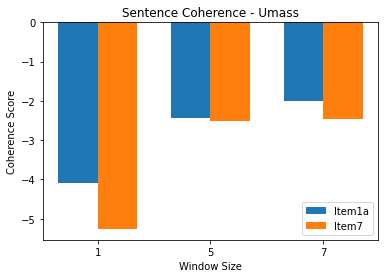

In [21]:
item1a = [-4.0796, -2.4353, -2.0128]
item7 = [-5.2741, 0.5924, -2.4623]

x = []
labels = ["1", "5", "7"]
x = np.arange(len(labels))
title="Sentence Coherence - Umass"
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, item1a, width, label='Item1a')
rects2 = ax.bar(x + width / 2, item7, width, label='Item7')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coherence Score')
ax.set_xlabel('Window Size')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
# fig.tight_layout()
plt.show()

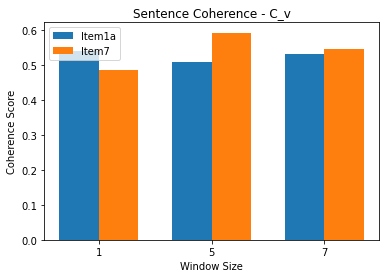

In [22]:
item1a = [0.5407, 0.5097, 0.5316]
item7 = [0.4854, 0.5924, 0.5446]

x = []
labels = ["1", "5", "7"]
x = np.arange(len(labels))
title="Sentence Coherence - C_v"
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, item1a, width, label='Item1a')
rects2 = ax.bar(x + width / 2, item7, width, label='Item7')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coherence Score')
ax.set_xlabel('Window Size')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
# fig.tight_layout()
plt.show()